In [1]:
%load_ext autoreload
%autoreload 1

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

%aimport ase_matrix
%aimport plotlib
%aimport toolkit
%aimport util
%aimport qc
%aimport workspace_manager

workspace = workspace_manager.WorkspaceManager(
    task_name="counts_to_ase",
    experiment_info={"data" : "scDNA"},
    verbose=True
)
requirements = {
    dtype : f"{dtype}.pkl"
    for dtype in ["gene_counts", "scoring"]
}
workspace.load_workspace(requirements)

# Data loading

In [2]:
filtering_tag = "PC1_PC2_span"
quantile = "75%"
clustering_tag = 'evo_dist_9'

data = {
    dtype : 
    util.pickle_load(workspace.tmp_data[dtype])
    for dtype in tqdm_notebook(
        requirements,
        "loading datasets into RAM"
    )
}
data_name = workspace.experiment_info['data']
sample_name = workspace.experiment_info['sample']
print(f"Currently working on {data_name}, {sample_name}")

data["clustering"] = util.pickle_load(
    f"{workspace.dir}"
    f"/{clustering_tag}_clustering.pkl"
)
data["clustering"].head()


Currently working on scDNA, first_sample


,BARCODE,CELL_ID,LABEL
0,AAACCTGTCTTGCGAA-1,1,9
1,AACTCCCAGGGATTCG-1,10,8
2,CACCTTGAGAAGGACA-1,100,6
3,CACCTTGAGGTAAACT-1,101,2
4,CAGAGAGGTTCCCACT-1,104,5


# Selecting genes

In [3]:
norm_summary = data["scoring"]\
                .NORM\
                .describe(percentiles=np.arange(0,1,0.05))

top_genes = data["scoring"][
    data["scoring"].NORM > norm_summary[quantile]
].GENE_ID

data["scoring"]["ABOVE_THRESHOLD"] = 0
data["scoring"]["ABOVE_THRESHOLD"][top_genes.index] = 1

print(f"Selected pool of {len(top_genes)} genes")

Selected pool of 8100 genes


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Analyzing selected genes

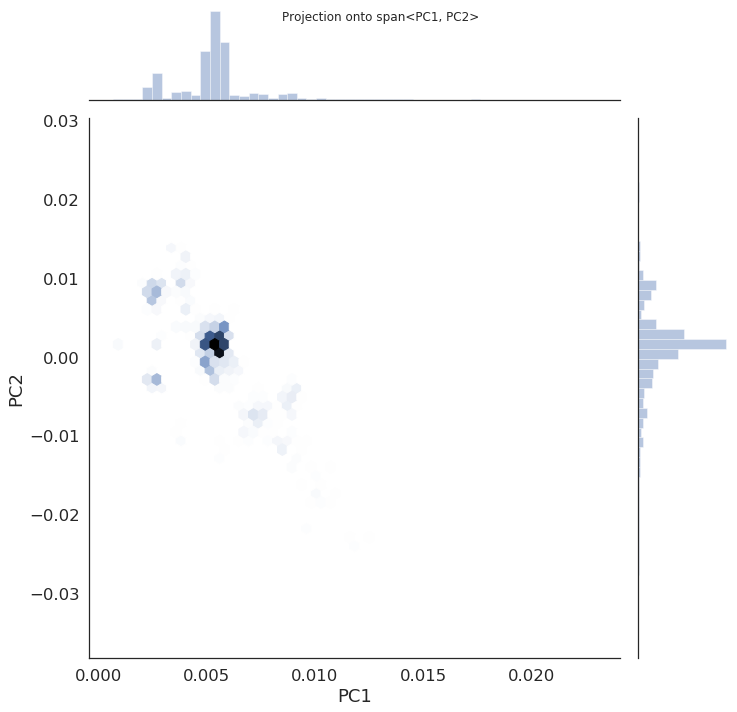

In [4]:
with sns.axes_style("white"):
    g = sns.jointplot(
        x="PC1", y="PC2",
        data=data["scoring"],
        kind="hex",
        height=10,
    );
    g.fig.suptitle("Projection onto span<PC1, PC2>")
    outfile = f"{workspace.img_dir}/projection_PC1_PC2_kdeplot.pdf"
    g.fig.savefig(
        outfile,
        format=outfile.split('.')[-1], 
        dpi=300
    )

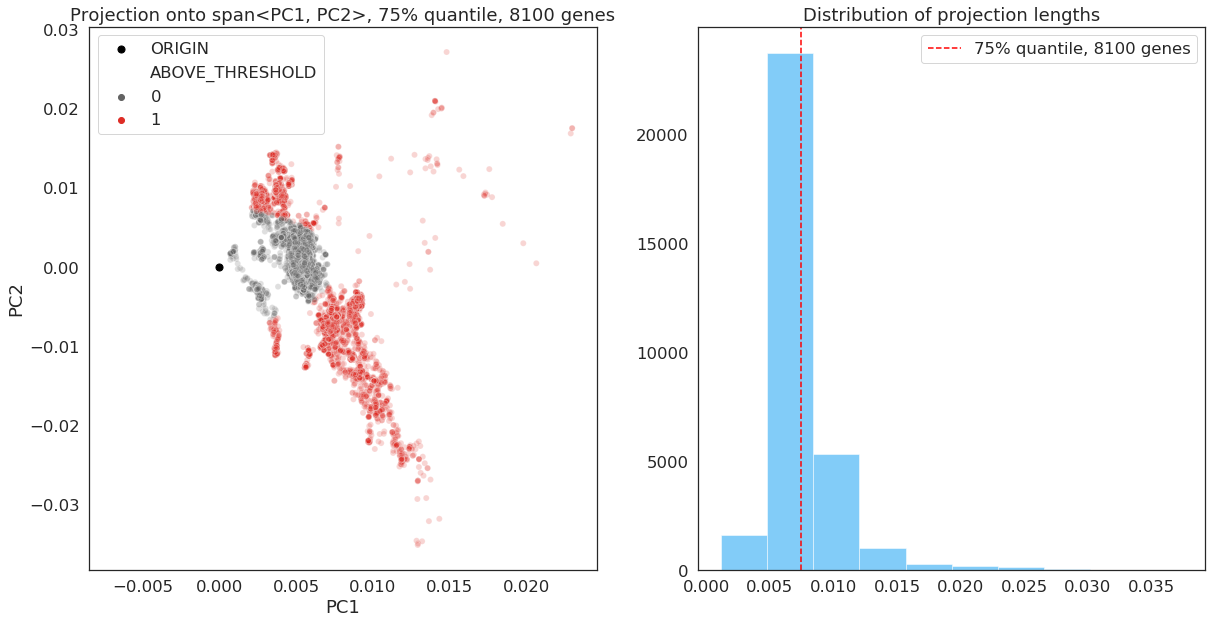

In [5]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    ax[0].set_title(
        f"Projection onto span<PC1, PC2>, {quantile} quantile,"
        f" {top_genes.size} genes"
    )
    ax[0].scatter(0, 0, s=50, label="ORIGIN", color="black")
    norm = plt.Normalize(vmin=0, vmax=1)
    sns.scatterplot(
        x="PC1", y="PC2", 
        hue="ABOVE_THRESHOLD",
        hue_norm=norm,
        data=data["scoring"], 
        ax=ax[0],
        palette={
            0 : "#636363",
            1 : "#de2d26"
        },
        alpha=0.2
    );
    ax[1].set_title("Distribution of projection lengths")
    ax[1].hist(data["scoring"].NORM, color="xkcd:azure", alpha=0.5);
    ax[1].axvline(
        norm_summary[quantile],
        color="red", linestyle="--",
        label=f"{quantile} quantile, {top_genes.size} genes"
    )
    ax[1].legend();
    outfile = (f"{workspace.img_dir}"
               f"/projection_PC1_PC2_{quantile}.png")
    fig.savefig(
        outfile, 
        format=outfile.split(".")[-1], 
        dpi=300
    )

# Filtering the genes in a count matrix

In [6]:
top_gene_counts_df = util.filter_by_isin(
    data['gene_counts'], 
    "GENE_ID", 
    top_genes
)
util.pickle_dump(
    top_gene_counts_df, 
    f"{workspace.tmp_dir}/{filtering_tag}_{quantile}"
    "_gene_counts.pkl"
)
workspace.add_entry(
    f"{filtering_tag}_{quantile}_gene_counts",
    f"{filtering_tag}_{quantile}_gene_counts.pkl"
)
top_gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Columns: 537 entries, GENE_ID to TTGGAACGTTCTGTCC-1_dp
dtypes: float64(536), object(1)
memory usage: 16.4+ MB


In [7]:
top_ase_df = ase_matrix.compute_ase(
    top_gene_counts_df, 
    toolkit.extract_barcodes(top_gene_counts_df)
)
util.pickle_dump(
    top_ase_df, 
    f"{workspace.tmp_dir}/{filtering_tag}_{quantile}_ase.pkl"
)
workspace.add_entry(
    f"{filtering_tag}_{quantile}_ase",
    f"{filtering_tag}_{quantile}_ase.pkl"
)

In [8]:
top_clustered_gene_counts_df = toolkit.aggregate_by_barcode_groups(
    top_gene_counts_df, 
    data['clustering']
)
top_clustered_gene_counts_df.head()

,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,918.0,1998.0,990.0,2092.0,579.0,1263.0,538.0,1294.0,648.0,1469.0,584.0,1277.0,533.0,1078.0,318.0,669.0,320.0,665.0
1,0.0,16.0,0.0,20.0,0.0,11.0,3.0,14.0,3.0,16.0,5.0,16.0,0.0,6.0,0.0,4.0,2.0,7.0
2,349.0,735.0,457.0,881.0,194.0,411.0,257.0,532.0,285.0,582.0,240.0,472.0,188.0,437.0,153.0,329.0,118.0,263.0
3,44.0,88.0,55.0,117.0,32.0,93.0,33.0,75.0,42.0,85.0,35.0,65.0,35.0,68.0,21.0,43.0,35.0,53.0
4,319.0,727.0,359.0,768.0,142.0,364.0,211.0,425.0,225.0,492.0,192.0,433.0,149.0,309.0,84.0,224.0,114.0,254.0


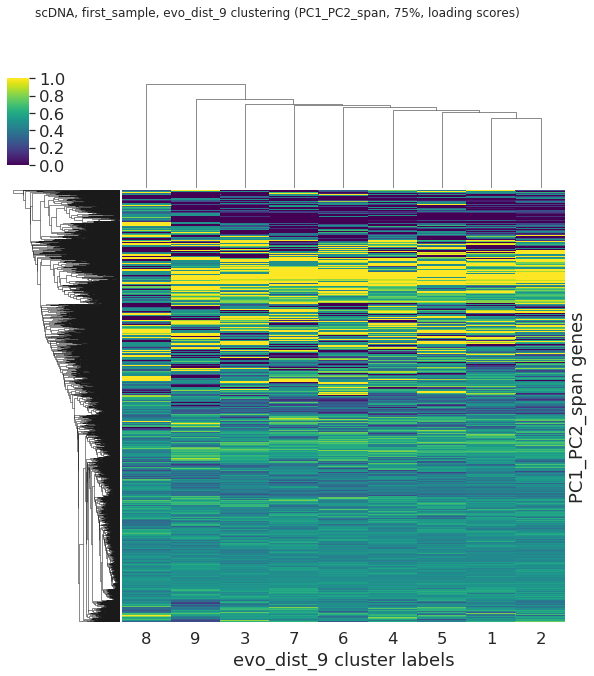

In [9]:
top_ase_df = ase_matrix.compute_ase(
    top_clustered_gene_counts_df, 
    toolkit.extract_cluster_labels(data['clustering'])
)
ase_matrix.plot_ase(
    top_ase_df,
    title=(f"{data_name}, {sample_name}, {clustering_tag} clustering"
           f" ({filtering_tag}, {quantile}, loading scores)"),
    xlabel=f"{clustering_tag} cluster labels",
    ylabel=f"{filtering_tag} genes",
    row_cluster=True,
    outfile=(f"{workspace.img_dir}"
             f"/{filtering_tag}_{quantile}_{clustering_tag}"
             "_ase.pdf")
)
util.pickle_dump(
    top_ase_df, 
    f"{workspace.tmp_dir}"
    f"/{filtering_tag}_{quantile}_{clustering_tag}_ase.pkl"
)
workspace.add_entry(
    f"{filtering_tag}_{quantile}_{clustering_tag}_ase",
    f"{filtering_tag}_{quantile}_{clustering_tag}_ase.pkl"
)

In [10]:
workspace.verify()
workspace.status()
workspace.push()

Staged for commit: 
	-PC1_PC2_span_75%_gene_counts : PC1_PC2_span_75%_gene_counts.pkl
	-PC1_PC2_span_75%_ase : PC1_PC2_span_75%_ase.pkl
	-PC1_PC2_span_75%_evo_dist_9_ase : PC1_PC2_span_75%_evo_dist_9_ase.pkl


/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/PC1_PC2_span_75%_gene_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/PC1_PC2_span_75%_gene_counts.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/PC1_PC2_span_75%_ase.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/PC1_PC2_span_75%_ase.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/tmp/counts_to_ase/first_sample/scDNA/PC1_PC2_span_75%_evo_dist_9_ase.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/processed/first_sample/scDNA/PC1_PC2_span_75%_evo_dist_9_ase.pkl
